In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')

#create mkt share data
blp_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices','demand_instruments0']

nonlinear_cols = ['csr_pay_94','EHBPercentTotalPremium']#,'SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']
#['act_value','csr_pay_94','csr_pay_87','SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']

linear_cols = [ 'act_value','MetalLevel_Platinum', 'MetalLevel_Silver','Plan Counts']#
#['CompositeRatingOffered_No','MetalLevel_Silver','MetalLevel_Platinum',
# 'BeginPrimaryCareCostSharingAfterNumberOfVisits' , 'csr_tot', 'csr_tot_94', 'PlanType_Indemnity']            
#'CSRVariationTypeBinary','DentalOnlyPlan_No','CompositeRatingOffered_No',

firm_cols =  linear_cols+ nonlinear_cols    
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE','S1701_C01_017E','StateCodeFL'] #'DP03_0001PE'


keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

def create_blp_data(df):
    
    #create market data...
    df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']

    #add blp columns
    df['prices'] = df['PREMI27']
    df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 
    df['market_ids'] = df['County']
    df['firm_ids'] = df['IssuerId']

    #demand_instrument0
    MktIds = np.array(pd.get_dummies(df['IssuerId']))
    MktIds2 = (MktIds.T).dot(MktIds)
    dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
    df['demand_instruments0'] = dummies_proj.dot(df['prices']) #average price across markets


    #fix problematic columns =
    df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                      'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                           'Total Number of Consumers':'csr_tot',
                            'Number of Consumers with CSR AV of 94%':'csr_tot_94'})

    #'DP05_0072PE', ,

    blp_data = df[blp_keys+linear_cols+nonlinear_cols+mkt_cols+['DP03_0095E']]


    #standardize the cols
    for col in firm_cols:
        #this line is causing a warning?
        blp_data[col] = blp_data[col]/blp_data[col].var()

    #zero shares are not okay?
    blp_data = blp_data[blp_data['shares']!=0]
    return blp_data,df
    
blp_data,df = create_blp_data(df)
blp_data  = blp_data.fillna(0)

print(blp_data['prices'].mean(),(1-blp_data['shares'].mean()))
print(df['Ever Enrolled Count'].sum())

142.14997349144596 0.9864361485032451
9870266.0


/tmp/ipykernel_99122/36268130.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blp_data[col] = blp_data[col]/blp_data[col].var()


In [3]:
num_trials = 5
training_test = []

#initilize folds
np.random.seed()
kf = KFold(n_splits=num_trials,shuffle=True)
folds_indexes = kf.split(blp_data)

for fold_index in folds_indexes:
    np.random.seed()
    X_train = blp_data.iloc[fold_index[0]]
    X_test = blp_data.iloc[fold_index[1]]
    training_test.append( (X_train, X_test) )

In [4]:
mses = []
r2s = []
model_fit = None
pred_shares = None
true_shares = None
blp_pred = None

for i in range(num_trials):
    X_train, X_test = training_test[i]
    model = sm.Logit(X_train['shares'],
                     sm.add_constant(X_train[linear_cols+nonlinear_cols+mkt_cols+['demand_instruments0']]))
    model_fit = model.fit(disp=0)
    
    pred_shares = model_fit.predict(
        sm.add_constant(X_test[linear_cols+nonlinear_cols+mkt_cols+['demand_instruments0']]))
    
    #make predictions/figure out error
    blp_pred = pred_shares*X_test['DP03_0095E']
    true_shares = X_test['shares']*X_test['DP03_0095E']
    error = blp_pred - true_shares
    
    mse = float( (error**2).mean() )
    r2 = float( 1 - mse/true_shares.var() ) 
    mses.append(mse)
    r2s.append(r2)
    print('------------------')
    print('mse normalized trial ', i,': r2', r2)#, mse, float(true_shares.var()) )
    print('training', (X_train['shares']*X_train['DP03_0095E']).mean() ,
          'predicted share', blp_pred.mean() ,'actual', true_shares.mean())
    print('------------------')
    
mses,r2s = np.array(mses),np.array(r2s)
enrollments = blp_data['shares']*blp_data['DP03_0095E']
print( 'mse', np.array(mses).mean() ,'r2', 1 - float( mses.mean()/enrollments.var()) )
print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )

------------------
mse normalized trial  0 : r2 0.32813883223683626
training 1245.5378138156868 predicted share 1523.0419614094628 actual 1173.71072319202
------------------
------------------
mse normalized trial  1 : r2 0.09009144820878434
training 1224.6656790893499 predicted share 1671.2213716590559 actual 1257.1602244389028
------------------
------------------
mse normalized trial  2 : r2 0.46372371055959827
training 1234.9851886498284 predicted share 1450.315279393963 actual 1215.8895820336868
------------------
------------------
mse normalized trial  3 : r2 0.21792584886336286
training 1252.3620205799814 predicted share 1441.6919625839942 actual 1146.3605739238926
------------------
------------------
mse normalized trial  4 : r2 0.23252139614472578
training 1198.2856251948863 predicted share 1617.7884588931167 actual 1362.7336244541484
------------------
mse 19124082.914940752 r2 0.2288458616172454
mse med 11215804.647111718 r2 med 0.32813883223683626


/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


                           Logit Regression Results                           
Dep. Variable:                 shares   No. Observations:                 6414
Model:                          Logit   Df Residuals:                     6402
Method:                           MLE   Df Model:                           11
Date:                Wed, 27 Apr 2022   Pseudo R-squ.:                     inf
Time:                        19:34:02   Log-Likelihood:                -100.38
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -5.2968      0.634     -8.349      0.000      -6.540      -4.053
act_value                  5.0708     12.416      0.408      0.683     -19.265      29.406
Meta

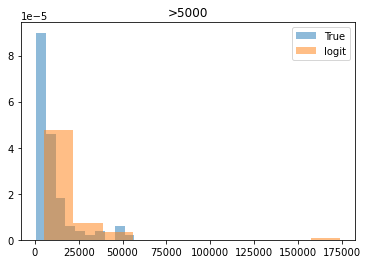

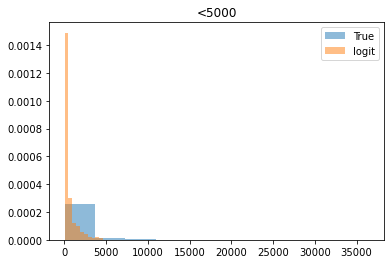

In [5]:
#print fit
print(model_fit.summary())

#evaluating model fit...
blp_pred = pred_shares*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']

split = 5000
plt.title('>'+str(split))
plt.hist(blp_pred[true_shares >=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares >=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()


plt.title('<'+str(split))
plt.hist(blp_pred[true_shares <=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares <=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()

In [6]:
def report_error(X_test,pred_shares):
    pred_shares = np.array(pred_shares.copy())
    X_test = X_test.copy()
    X_test['error'] =  ((X_test['shares']- pred_shares)*X_test['DP03_0095E'])**2
    X_test['pred'] = pred_shares*X_test['DP03_0095E']
    result = X_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('_x',''))    
    result = result.sort_values('error',ascending=False).head(50) 

    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

print(report_error(X_test,pred_shares))

               pred  Ever Enrolled Count      pred_var    enroll_var  count
State                                                                      
IL     34853.692829          9532.666667  22237.640881   8593.809536      3
FL     22624.074108         30985.000000  14831.033404  51902.220569     10
TX     20478.073172         10784.833333   8977.628578  12079.921066      6
NV     14781.685855         47446.000000           NaN           NaN      1
PA     14196.616291          7904.166667   1920.552261   8338.731184      6
MI     13636.034447          1218.800000   4805.416803    894.344844      5
VA     12787.330944         30097.000000   3424.519694   3326.230299      2
NJ     12003.718451          5642.833333   1696.583737   8924.647476      6
AZ     10965.284360         19294.000000           NaN           NaN      1
NC      9226.744552         48209.000000           NaN           NaN      1
WI      9049.267735         28963.000000           NaN           NaN      1
OH      8946